In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# plot style
mpl.rcParams['font.family'] = 'Segoe UI'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titlepad'] = 4
mpl.rcParams['axes.titleweight'] = 400

# dark mode
mpl.rcParams['figure.facecolor'] = '#1e1e1e'
mpl.rcParams['axes.facecolor'] = '#1e1e1e'
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.titlecolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['text.color'] = 'white'

# dpi and figsize
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%matplotlib inline

FROM_API = True

## Wczytywanie danych z API

https://hardcover.app/account/api

https://cloud.hasura.io/public/graphiql?endpoint=https://api.hardcover.app/v1/graphql

Jeśli korzystasz z `FROM_API=True`, pamiętaj o ustawieniu zmiennej środowiskowej HARDCOVER_API_KEY.

Wszystkich książek: 1548811  
\>10 ratingów: 16728  
\>10 ratingów i >3 tagi: 11249

In [2]:
if FROM_API:
    import requests, os
    from collections import defaultdict
    from dotenv import load_dotenv
    load_dotenv()
    url = 'https://api.hardcover.app/v1/graphql'
    headers = {
        'Authorization': 'Bearer ' + os.getenv('HARDCOVER_API_KEY'),
        'Content-Type': 'application/json'
    }

    # Books with more than 10 ratings and more than 3 tags
    query = lambda x: """
      query Books {
        books(
          where: {
            ratings_count: {_gt: 10},
            taggings_aggregate: {
              count: {predicate: {_gt: 3}}
            }
          }
          order_by: {id: asc}
          offset: """+str(x*1000)+"""
          limit: 1000
        ) {
          id
          title
          rating
          ratings_count
          ratings_distribution
          release_year
          pages
          users_count
          reviews_count
          editions_count
          lists_count
          journals_count
          taggings {
            tag {
              tag
              tag_category {
                category
              }
            }
          }
        }
      }
      """
    books = []
    for i in range(1000):
        res = requests.post(url, headers=headers, json={'query': query(i)})
        res = res.json().get("data", {}).get("books", [])
        if not res: break
        books += res
    
    for book in books:
        # Ratings
        ratings = book.get("ratings_distribution", {})
        book["ratings"] = {r['rating']: r['count'] for r in ratings}
        del book["ratings_distribution"]

        # Categories
        categories = defaultdict(list)
        for tagging in book.get("taggings", []):
            tag = tagging["tag"]["tag"]
            category = tagging["tag"]["tag_category"]["category"]
            categories[category].append(tag)
        book.update(categories)
        del book["taggings"]
    pd.DataFrame(books).convert_dtypes().set_index('id').to_csv('books.csv')
data = pd.read_csv('books.csv').convert_dtypes().set_index('id')
eval_cols = ['ratings', 'Genre', 'Mood', 'Pace', 'Tag', 'Content Warning', 'Member']
data[eval_cols] = data[eval_cols].fillna('[]').map(eval)
data

,title,rating,ratings_count,release_year,pages,users_count,reviews_count,editions_count,lists_count,journals_count,ratings,Genre,Mood,Pace,Tag,Content Warning,Member
id,,,,,,,,,,,,,,,,,
15,Cybele's Secret,4.071429,14,2007,448,25,2,5,14,25,"{2.0: 1, 3.0: 3, 4.0: 4, 5.0: 6}","[Fantasy, Young Adult, Adventure, Fiction, His...",[],[],[],[],[]
42,Notes from Underground,4.081699,153,1847,149,555,17,121,176,537,"{1.0: 1, 2.0: 5, 2.5: 1, 3.0: 22, 3.5: 5, 4.0:...","[Classics, Classics, Realistic Fiction, Philos...","[challenging, emotional, mysterious, dark, ref...","[slow, medium, medium, slow]","[Character driven, Strong Character Developmen...",[],[]
59,Holding Up the Universe,3.5,43,2016,402,106,7,8,42,107,"{1.0: 1, 1.5: 1, 2.0: 7, 3.0: 13, 4.0: 10, 5.0...","[Romance, Young Adult, Fiction, General, Young...",[],[],[],[],[]
64,The Dip: A Little Book That Teaches You When t...,3.423729,59,2007,106,148,6,5,46,150,"{1.0: 2, 2.0: 10, 3.0: 17, 4.0: 21, 5.0: 9}","[Business, Nonfiction, Psychology, Business & ...","[informative, inspiring, reflective, lighthear...","[fast, medium]",[],[],[]
80,Cell,3.419118,136,2006,496,257,10,37,116,253,"{1.0: 6, 1.5: 1, 2.0: 17, 3.0: 48, 3.5: 1, 4.0...","[Science fiction, Fantasy, Dystopian, Fiction,...","[Adventurous, dark, tense, challenging, dark, ...","[medium, slow]","[Plot driven, Weak Character Development, Love...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444468,The Cinnamon Bun Book Store,3.461538,13,2024,347,44,2,3,24,28,"{1.0: 1, 3.0: 4, 3.5: 3, 4.0: 3, 4.5: 1, 5.0: 1}","[Romance, Cozy, Fiction, Fantasy]",[Cozy],[],[],[],[]
1487609,The Underground Railroad,4.056985,272,2016,306,645,37,15,256,132,"{1.0: 1, 2.0: 8, 2.5: 1, 3.0: 59, 4.0: 104, 4....","[Fantasy, Historical Fiction, American History...","[dark, sad, Adventurous, challenging, dark, Ad...","[slow, medium, medium, medium, medium, medium,...","[Plot driven, Weak Character Development, Unlo...","[death, Violence, Oppression, misogyny, Racism...",[]
1488736,The Twenty-One Balloons,3.666667,12,1947,193,19,1,1,30,1,"{2.0: 1, 3.0: 3, 4.0: 7, 5.0: 1}","[Juvenile Fiction, Fantasy, Classics, Adventur...",[],[],[],[],[]


## Wizualizacja danych

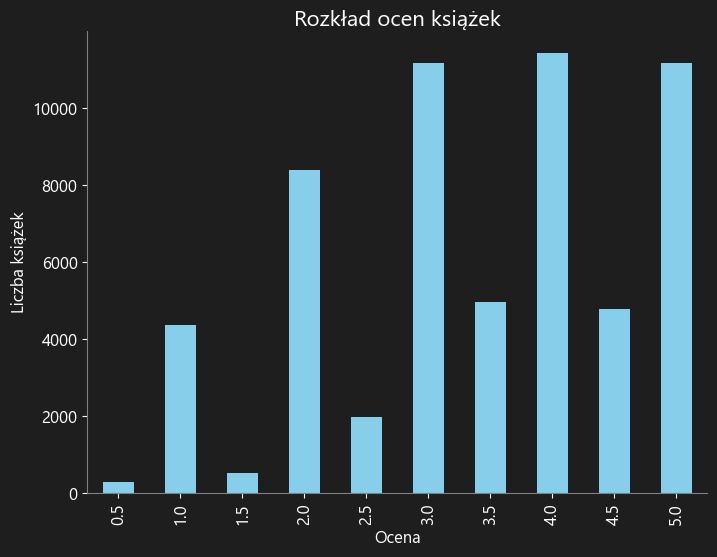

In [3]:
# Rozkład ocen książek
ratings = data['ratings'].apply(lambda x: x.keys()).explode()
ratings.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rozkład ocen książek')
plt.xlabel('Ocena')
plt.ylabel('Liczba książek')
plt.show()

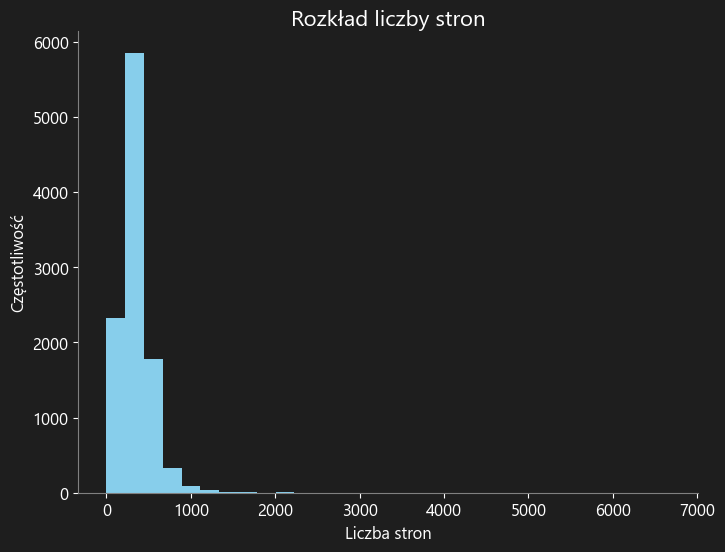

In [4]:
# Rozkład liczby stron
data['pages'].plot(kind='hist', bins=30, color='skyblue')
plt.title('Rozkład liczby stron')
plt.xlabel('Liczba stron')
plt.ylabel('Częstotliwość')
plt.show()

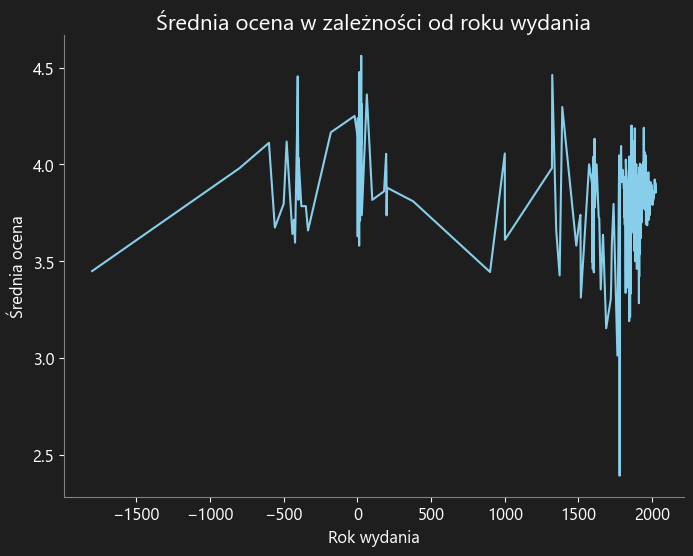

In [5]:
# Średnia ocena w zależności od roku wydania
avg_rating_by_year = data.groupby('release_year')['rating'].mean()
avg_rating_by_year.plot(kind='line', color='skyblue')
plt.title('Średnia ocena w zależności od roku wydania')
plt.xlabel('Rok wydania')
plt.ylabel('Średnia ocena')
plt.show()

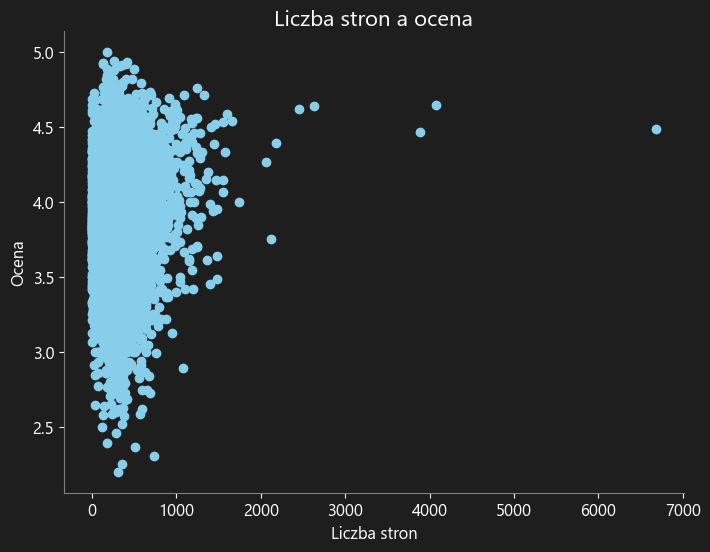

In [6]:
# Liczba stron a ocena
df = data.dropna(subset=['pages', 'rating'])
plt.scatter(df['pages'], df['rating'], color='skyblue')
plt.title('Liczba stron a ocena')
plt.xlabel('Liczba stron')
plt.ylabel('Ocena')
plt.show()

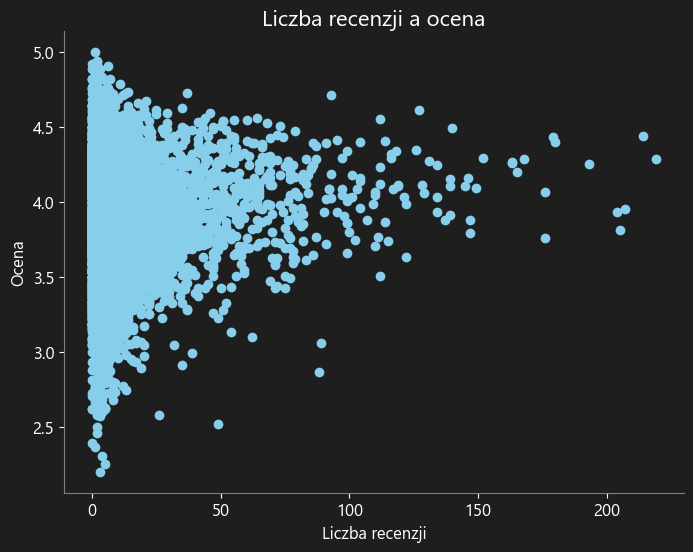

In [7]:
# Liczba recenzji a ocena
plt.scatter(data['reviews_count'], data['rating'], color='skyblue')
plt.title('Liczba recenzji a ocena')
plt.xlabel('Liczba recenzji')
plt.ylabel('Ocena')
plt.show()

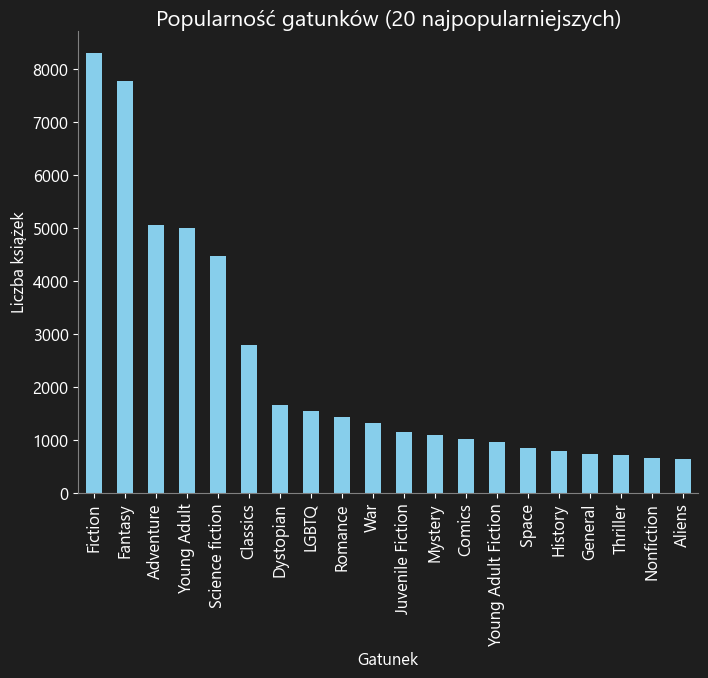

In [8]:
# Popularność gatunków (20 najpopularniejszych)
genres = data['Genre'].explode()
top_genres = genres.value_counts().nlargest(20)
top_genres.plot(kind='bar', color='skyblue')
plt.title('Popularność gatunków (20 najpopularniejszych)')
plt.xlabel('Gatunek')
plt.ylabel('Liczba książek')
plt.show()

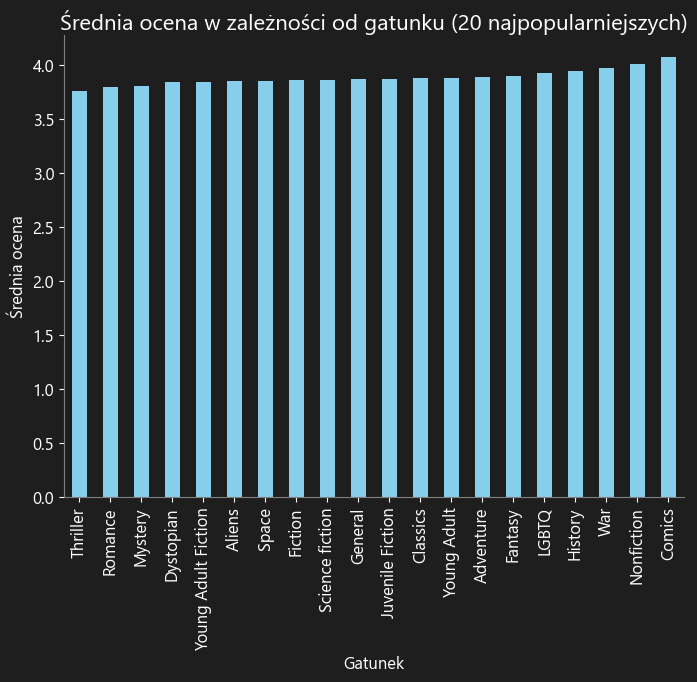

In [9]:
# Średnia ocena w zależności od gatunku (20 najpopularniejszych)
genres = data['Genre'].explode()
genre_ratings = data.explode('Genre').groupby('Genre')['rating'].mean()
genre_ratings[top_genres.index].sort_values().plot(kind='bar', color='skyblue')
plt.title('Średnia ocena w zależności od gatunku (20 najpopularniejszych)')
plt.xlabel('Gatunek')
plt.ylabel('Średnia ocena')
plt.show()

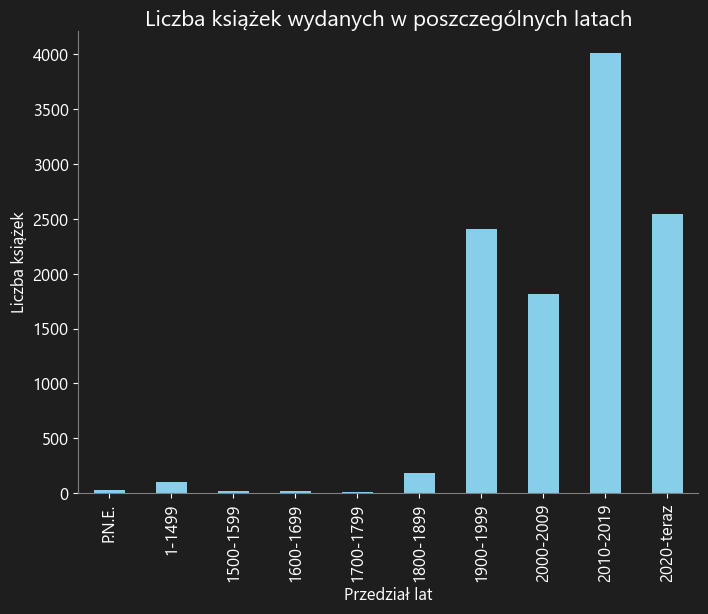

In [10]:
# Liczba książek wydanych w poszczególnych latach
bins = [-1000, 1, 1500, 1600, 1700, 1800, 1900, 2000, 2010, 2020, 3000]
labels = ['P.N.E.', '1-1499', '1500-1599', '1600-1699', '1700-1799', '1800-1899', '1900-1999', '2000-2009', '2010-2019', '2020-teraz']
data['year_bins'] = pd.cut(data['release_year'], bins=bins, labels=labels, right=False)
books_per_year_bin = data['year_bins'].value_counts().sort_index()
books_per_year_bin.plot(kind='bar', color='skyblue')
plt.title('Liczba książek wydanych w poszczególnych latach')
plt.xlabel('Przedział lat')
plt.ylabel('Liczba książek')
plt.show()

## Predykcja z użyciem modelu Gradient Boosting

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Preprocessing
df = data[['rating', 'ratings', 'release_year', 'pages',
           'editions_count', 'lists_count', 'journals_count',
           'reviews_count', 'Genre', 'Mood', 'Content Warning',
           'Tag']].dropna()
print(df.shape)

top_values = {
    'Genre': df['Genre'].explode().value_counts().nlargest(50).index,
    'Mood': df['Mood'].explode().value_counts().nlargest(15).index,
    'Content Warning': df['Content Warning'].explode().value_counts().nlargest(5).index,
    'Tag': df['Tag'].explode().value_counts().nlargest(5).index
}

for column, top in top_values.items():
    df[column] = df[column].apply(lambda x: [i if i in top else column+'_inne' for i in x])

mlb = MultiLabelBinarizer()
for column in top_values.keys():
    df = df.join(pd.DataFrame(mlb.fit_transform(df[column]), columns=mlb.classes_, index=df.index))
df = df.drop(columns=['Genre', 'Mood', 'Content Warning', 'Tag', 'ratings'])

# Normalize numeric columns
scaler = StandardScaler()
numeric_cols = ['release_year', 'pages', 'editions_count', 'lists_count', 'journals_count', 'reviews_count']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Split data
X = df.drop('rating', axis=1).astype("float32")
y = df['rating'].astype("float32")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

# Model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

(10428, 12)
MSE: 0.09939918948859944


## Predykcja z użyciem sieci neuronowej

In [13]:
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import l2
import keras

keras.utils.set_random_seed(314)
model = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(192, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(48, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')
])
model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
)

y_pred = model.predict(X_test).flatten()
print('MSE:', mean_squared_error(y_test, y_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        44,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        98,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,849 (604.88 KB)

 Trainable params: 153,345 (599.00 KB)

 Non-trainable params: 1,504 (5.88 KB)

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 16.2999 - mae: 3.8001 - val_loss: 11.2100 - val_mae: 3.3205
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 13.5135 - mae: 3.5375 - val_loss: 10.7383 - val_mae: 3.2391
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 11.3293 - mae: 3.2554 - val_loss: 9.0002 - val_mae: 2.9602
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.1566 - mae: 2.9135 - val_loss: 6.9710 - val_mae: 2.5938
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.8862 - mae: 2.5039 - val_loss: 5.0650 - val_mae: 2.1917
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.7988 - mae: 2.0494 - val_loss: 3.2995 - val_mae: 1.7501
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.0921 - mae: 1.5939 - val_loss: 1.9315 - val_mae: 1.2964
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.8807 - mae: 1.1850 - val_loss: 0.9920 - val_mae: 0.8963
Epoch 9/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11

In [14]:
model = keras.models.load_model('hardcover.keras')
y_pred = model.predict(X_test).flatten()
print('MSE:', mean_squared_error(y_test, y_pred))

c:\Users\jurek\PWR\2stopien\3semestr\Technologie webowe\hardcover\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MSE: 0.095688894
